# Autoencoder

Set some global parameters

In [1]:
# Whether to rotate data in an orientation indiepndent manner or not.
USE_ORIENTATION_INDIPENDENT_TRANSFORMATION = True

# Whether to normalize data or not.
# Note: we usually do not normalize beacause the distance between points
# and reconstructed points gets reduced but the signal is not well represented
USE_NORMALIZATION = False

# Whether to use Bryan dataset as validation dataset or not.
USE_BRYAN_VALIDATION_DATASET = True

USE_ALL_POSITION_BRYAN_DATASET = True

In [2]:
def get_settings():
    """
    Return a string which encodes current global settings.
    Can be used as name of files.
    """
    oit = "oit_" if USE_ORIENTATION_INDIPENDENT_TRANSFORMATION else ""
    norm = "norm_" if USE_NORMALIZATION else ""
    bryan = "bryan_" if USE_BRYAN_VALIDATION_DATASET else ""
    allpos = "allpos_" if USE_ALL_POSITION_BRYAN_DATASET else ""
    return oit + norm + bryan + allpos

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import layers

from autoencoder_utils import show_samples, show_loss, show_mse, show_reconstructed_signals, show_reconstruction_errors
from keras_utils import ModelSaveCallback
from orientation_indipendend_transformation import orientation_independent_transformation

In [4]:
random.seed(42)
np.random.seed(42)

## Load dataset

In [5]:
def load_dataset(data_filename="dataset.csv", label_filename="labels.csv", dataset_dir="./datasets"):
    data = pd.read_csv(os.path.join(dataset_dir, data_filename), header=None, names=range(750))
    labels = pd.read_csv(os.path.join(dataset_dir, label_filename), header=None, names=["user", "model", "label"])

    return data, labels

In [6]:
def print_stats(ds: pd.DataFrame):
    print("Shape", ds.shape)
    print("Columns", ds.columns)

In [7]:
X_df_reference, y_df_reference = load_dataset("dataset_50_2.5.csv", "dataset_labels_50_2.5.csv", dataset_dir="./datasets/our2")
X_df_reference_validation, y_df_reference_validation = pd.read_csv("./datasets/bryan/dataset_50_2.5.csv", header=None, names=range(750)), pd.read_csv("./datasets/bryan/dataset_labels_50_2.5.csv", header=None, names=["user", "model", "label", "position"]),

In [8]:
print_stats(X_df_reference)
print_stats(y_df_reference)
print_stats(X_df_reference_validation)
print_stats(y_df_reference_validation)

Shape (22589, 750)
Columns Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            740, 741, 742, 743, 744, 745, 746, 747, 748, 749],
           dtype='int64', length=750)
Shape (22589, 3)
Columns Index(['user', 'model', 'label'], dtype='object')
Shape (4790, 750)
Columns Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            740, 741, 742, 743, 744, 745, 746, 747, 748, 749],
           dtype='int64', length=750)
Shape (4790, 4)
Columns Index(['user', 'model', 'label', 'position'], dtype='object')


## Preprocessing

In [9]:
def get_label(x):
    return x[2]

In [10]:
def restructure(x):
    return x.reshape(-1, 6, 125)

In [11]:
def normalize(x):
    min_val = np.max(x)
    max_val = np.min(x)
    
    x = (x - min_val) / (max_val - min_val)
    
    return x

### Training Set

In [12]:
X_df, y_df = X_df_reference.copy(), y_df_reference.copy()

In [13]:

# *** MERGE LABELS
# Merge sit and stand labels
sit_or_stand_filter = (y_df["label"] == "sit") | (y_df["label"] == "stand")
y_df["label"].loc[sit_or_stand_filter] = "no_activity"

# Merge stairs activity
#stairsdown_or_stairsup_filter = (y_df["label"] == "stairsdown") | (y_df["label"] == "stairsup")
#y_df["label"].loc[stairsdown_or_stairsup_filter] = "stairs"

# *** SHUFFLE
X_shuffled_df = X_df.sample(frac=1)
y_shuffled_df = y_df.reindex(X_shuffled_df.index)

# *** TRAIN AND TEST
if USE_BRYAN_VALIDATION_DATASET:
    but_last_user_indicies = ~(y_df['user'] == "z")
else:
    but_last_user_indicies = ~((y_df['user'] == "a") | (y_df['user'] == "b"))

X_train_df = X_shuffled_df.loc[but_last_user_indicies]
X_test_df = X_shuffled_df.loc[~but_last_user_indicies]

y_train_df = y_shuffled_df.loc[but_last_user_indicies]
y_test_df = y_shuffled_df.loc[~but_last_user_indicies]

print("X_train_df =", len(X_train_df))
print("X_test_df =", len(X_test_df))
print("y_train_df =", len(y_train_df))
print("y_test_df =", len(y_test_df))

assert len(X_train_df) == len(y_train_df), "X train and y train do not contain same number of samples"
assert len(X_test_df) == len(y_test_df), "X test and y test do not contain same number of samples"


X_train_df = 22589
X_test_df = 0
y_train_df = 22589
y_test_df = 0


In [14]:
# 1. Back to numpy
X_train = X_train_df.loc[:].to_numpy()
X_test = X_test_df.loc[:].to_numpy()

# 2. Restructure the array
X_train = restructure(X_train)
X_test = restructure(X_test)

# 3. Normalize
if USE_NORMALIZATION:
    X_train = normalize(X_train)
    X_test = normalize(X_test)

# 4. Orientation indipendent transformation
if USE_ORIENTATION_INDIPENDENT_TRANSFORMATION:
    X_train = orientation_independent_transformation(X_train)
    X_test = orientation_independent_transformation(X_test)

# 5. Get ground thruth
y_train = y_train_df.loc[:].to_numpy()
y_test = y_test_df.loc[:].to_numpy()

# 6. One hot (for classification)
y_train_hot = pd.get_dummies(y_train_df['label']).to_numpy()
y_test_hot = pd.get_dummies(y_test_df['label']).to_numpy()

# 7. Keep only label
y_train = np.array(list(map(get_label, y_train)))
y_test = np.array(list(map(get_label, y_test)))

: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value enc

In [15]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(22589, 6, 125)
(22589,)
(0,)
(0,)


Labels

In [16]:
classes = np.unique(y_train)
num_classes = len(np.unique(y_train))

print(f"Classes = {classes}")
print(f"Num classes = {num_classes}")

Classes = ['bike' 'no_activity' 'stairsdown' 'stairsup' 'walk']
Num classes = 5


Plot some samples

X[0]: bike


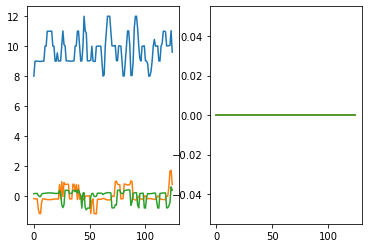

In [17]:
show_samples(X_train, y_train, n=1, is_random=False)

### Validation Set

In [18]:
X_df, y_df = X_df_reference_validation.copy(), y_df_reference_validation.copy()

# Keep valid positions only
if USE_ALL_POSITION_BRYAN_DATASET:
    valid_positions_indicies = ~(y_df["position"] == "none") 
else:
    valid_positions_indicies = (y_df["position"] == "right") | (y_df["position"] == "left") | (y_df["position"] == "top") | (y_df["position"] == "back") | (y_df["position"] == "bottom")

# Filter out other data
X_df = X_df.loc[valid_positions_indicies]
y_df = y_df.loc[valid_positions_indicies]

# Shuffle data
X_df = X_df.sample(frac=1)
y_df = y_df.reindex(X_df.index)

# Back to numpy arrays
X_validation = restructure(X_df.loc[:].to_numpy())
y_validation = y_df["label"].loc[:].to_numpy()

# Retrieve also one-hot encoding for y
y_validation_hot = pd.get_dummies(y_df['label']).to_numpy()

# Normalize
if USE_NORMALIZATION:
    X_validation = normalize(X_validation)

# Apply O.I.T.
if USE_ORIENTATION_INDIPENDENT_TRANSFORMATION:
    X_validation = orientation_independent_transformation(X_validation)

: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value enc

In [19]:
print(X_validation.shape)
print(y_validation.shape)
print(y_validation_hot.shape)

(4790, 6, 125)
(4790,)
(4790, 5)


X[0]: stairsdown


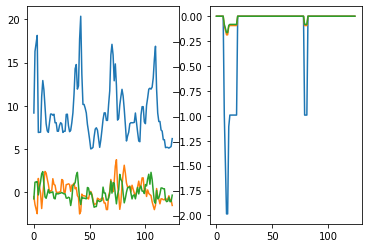

In [20]:
show_samples(X_validation, y_validation, n=1, is_random=False)

In [21]:
if USE_BRYAN_VALIDATION_DATASET:
    X_test = X_validation
    y_test = y_validation
    y_test_hot = y_validation_hot

Check size

In [22]:
assert X_train.shape[0] == y_train.shape[0], f"Invalid shape for X_train and y_train: {X_train.shape} != {y_train.shape}"
assert X_test.shape[0] == y_test.shape[0], f"Invalid shape for X_test and y_test: {X_test.shape} != {y_test.shape}"
assert X_test.shape[0] == y_test.shape[0], f"Invalid shape for X_test and y_test: {X_test.shape} != {y_test.shape}"
assert y_train_hot.shape == (y_train.shape[0],num_classes), f"Invalid shape of y_train_hot: {y_train_hot.shape}"
assert y_test_hot.shape == (y_test.shape[0],num_classes), f"Invalid shape of y_test_hot: {y_test_hot.shape}"

## Data Exploration

In [23]:
print("Users", y_df["user"].unique())
print("Models", y_df["model"].unique())
print("Classes", y_df["label"].unique())

Users ['a']
Models ['oneplus_8t']
Classes ['stairsdown' 'stairsup' 'walk' 'bike' 'no_activity']


Fraction of samples per label

In [24]:
print(y_df.groupby(["label"])["label"].count() / y_df["label"].count())

label
bike           0.242589
no_activity    0.241545
stairsdown     0.118998
stairsup       0.123591
walk           0.273278
Name: label, dtype: float64


Fraction of samples per user

In [25]:
print(y_df.groupby(["user"])["user"].count() / y_df["user"].count())

user
a    1.0
Name: user, dtype: float64


Fraction of samples per model

In [26]:
print(y_df.groupby(["model"])["model"].count() / y_df["model"].count())

model
oneplus_8t    1.0
Name: model, dtype: float64


Number of samples per user i and fraction of samples per class for user i

In [27]:
y_df_i = y_df.loc[y_df["user"] == "i"]

num_samples_i = y_df_i["label"].count()
fraction_of_samples_per_class_i = y_df_i.groupby(["label"])["label"].count() / y_df_i["label"].count()

print(num_samples_i)
print(fraction_of_samples_per_class_i)

0
Series([], Name: label, dtype: float64)


## Model (autoencoder)

X[0]: bike


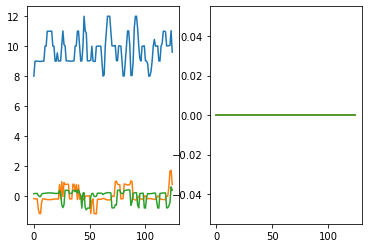

In [28]:
show_samples(X_train, y_train, n=1, is_random=False)

In [29]:
DATA_SHAPE = X_train.shape[1:]
CODE_SIZE=48

In [30]:
def build_encoder(data_shape, code_size):
    inputs = tf.keras.Input(data_shape)

    X = inputs    
    X = layers.Flatten()(X)
    X = layers.Dense(150, activation="relu")(X)
    X = layers.Dense(code_size, activation="sigmoid")(X)
    outputs = X
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [31]:

def build_decoder(data_shape, code_size):
    inputs = tf.keras.Input((code_size,))

    X = inputs
    X = layers.Dense(150, activation="relu")(X)
    X = layers.Dense(np.prod(data_shape), activation=None)(X)
    outputs = layers.Reshape(data_shape)(X)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [32]:
def build_autoencoder(encoder, decoder):
    inputs = tf.keras.Input(DATA_SHAPE)  # input
    codes = encoder(inputs)              # build the code with the encoder
    outputs = decoder(codes)             # reconstruction the signal with the decoder

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [33]:
encoder = build_encoder(DATA_SHAPE, CODE_SIZE)
decoder = build_decoder(DATA_SHAPE, CODE_SIZE)

In [34]:
autoencoder = build_autoencoder(encoder, decoder)

optimizer = "adam"
loss = "mse"

model_filename = 'autoencoder_network.hdf5'
last_finished_epoch = None
epochs=200
batch_size=128

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
save_model_checkpoint_callback = ModelSaveCallback(model_filename)

callbacks = [save_model_checkpoint_callback, early_stopping_callback]

autoencoder.compile(optimizer=optimizer, loss=loss)

history = autoencoder.fit(
    x=X_train, y=X_train, 
    epochs=epochs, 
    validation_data=(X_test, X_test), 
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1)

loss: 1.6501
Epoch 6/200
177/177 [==============================] - 1s 4ms/step - loss: 1.1520 - val_loss: 1.6172
Epoch 7/200
177/177 [==============================] - 1s 4ms/step - loss: 1.1023 - val_loss: 1.5849
Epoch 8/200
177/177 [==============================] - 1s 4ms/step - loss: 1.0690 - val_loss: 1.5573
Epoch 9/200
177/177 [==============================] - 1s 4ms/step - loss: 1.0551 - val_loss: 1.5406
Epoch 10/200
177/177 [==============================] - 1s 3ms/step - loss: 1.0405 - val_loss: 1.5077
Epoch 11/200
177/177 [==============================] - 1s 3ms/step - loss: 1.0198 - val_loss: 1.4866
Epoch 12/200
177/177 [==============================] - 1s 4ms/step - loss: 1.0009 - val_loss: 1.4557
Epoch 13/200
177/177 [==============================] - 1s 3ms/step - loss: 0.9891 - val_loss: 1.4342
Epoch 14/200
177/177 [==============================] - 1s 3ms/step - loss: 0.9754 - val_loss: 1.4199
Epoch 15/200
177/177 [==============================] - 1s 3ms/step - los

In [35]:
encoder.save("encoder.h5")

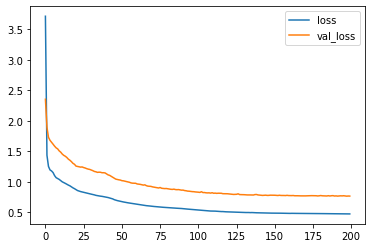

In [36]:
show_loss(history)

In [37]:
show_mse(autoencoder, X_test)

MSE = 0.7672549486160278


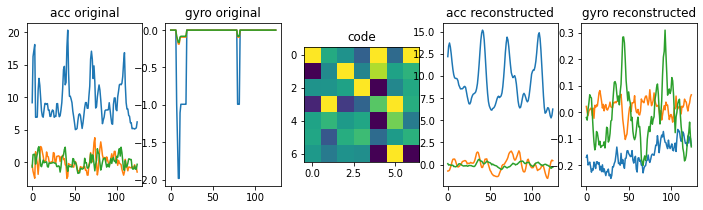

In [38]:
show_reconstructed_signals(X_test, encoder, decoder, n=1)

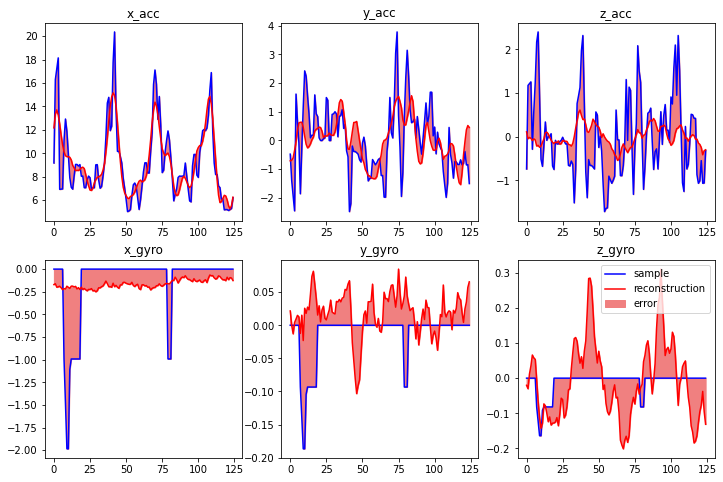

In [39]:
show_reconstruction_errors(X_test, encoder, decoder, n=1)

## KNN classifier

In [40]:
from sklearn.neighbors import KNeighborsClassifier

# prepare the codes
codes = encoder.predict(X_train)

assert codes.shape[1:] == (CODE_SIZE,), f"Predicted codes shape must be equal to code size, but {codes.shape[1:]} != {(CODE_SIZE,)}"

# create the k-neighbors calssifier
n_neighbors = num_classes
metric = "euclidean"

nbrs = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)

# fit the model using the codes
nbrs.fit(codes, y_train)

KNeighborsClassifier(metric='euclidean')

In [41]:
print("Classes =", nbrs.classes_)

Classes = ['bike' 'no_activity' 'stairsdown' 'stairsup' 'walk']


In [42]:
print("X_test[i] = y_true \t y_pred    \t with probs [...]")
print()

for i in range(20):
    x = X_test[i]
    y = y_test[i]

    c = encoder.predict(x[np.newaxis, :])[0]
    
    [lab] = nbrs.predict(c[np.newaxis, :])
    [probs] = nbrs.predict_proba(c[np.newaxis, :])

    print(f"X_test[{i}] = {y}\t {lab}   \t with probs {probs}")


X_test[i] = y_true 	 y_pred    	 with probs [...]

X_test[0] = stairsdown	 stairsdown   	 with probs [0. 0. 1. 0. 0.]
X_test[1] = stairsup	 stairsup   	 with probs [0. 0. 0. 1. 0.]
X_test[2] = walk	 walk   	 with probs [0. 0. 0. 0. 1.]
X_test[3] = bike	 bike   	 with probs [1. 0. 0. 0. 0.]
X_test[4] = bike	 bike   	 with probs [0.8 0.  0.  0.  0.2]
X_test[5] = walk	 walk   	 with probs [0.  0.  0.  0.4 0.6]
X_test[6] = walk	 walk   	 with probs [0. 0. 0. 0. 1.]
X_test[7] = bike	 bike   	 with probs [1. 0. 0. 0. 0.]
X_test[8] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[9] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[10] = walk	 walk   	 with probs [0. 0. 0. 0. 1.]
X_test[11] = stairsdown	 stairsdown   	 with probs [0. 0. 1. 0. 0.]
X_test[12] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[13] = walk	 bike   	 with probs [0.8 0.  0.  0.2 0. ]
X_test[14] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[15] = bik

In [43]:
from sklearn.metrics import classification_report

codes = encoder.predict(X_test)

y_true = y_test
y_pred = nbrs.predict(codes)

print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

        bike       0.66      0.95      0.78      1162
 no_activity       0.96      1.00      0.98      1157
  stairsdown       0.72      0.86      0.78       570
    stairsup       0.64      0.66      0.65       592
        walk       0.98      0.48      0.64      1309

    accuracy                           0.78      4790
   macro avg       0.79      0.79      0.77      4790
weighted avg       0.82      0.78      0.77      4790



## KMeans classifier

In [44]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import numpy as np

le = LabelEncoder()
le.fit(y_test)

# train
codes = encoder.predict(X_train)

kmeans = KMeans(n_clusters=num_classes, random_state=0)
kmeans.fit(codes)

# evaluate 
codes = encoder.predict(X_test)

y_true = y_test
y_pred = le.inverse_transform(kmeans.predict(codes))

print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

        bike       0.25      0.26      0.26      1162
 no_activity       0.23      0.63      0.34      1157
  stairsdown       0.00      0.00      0.00       570
    stairsup       0.00      0.00      0.00       592
        walk       0.00      0.00      0.00      1309

    accuracy                           0.21      4790
   macro avg       0.10      0.18      0.12      4790
weighted avg       0.12      0.21      0.14      4790



## NN classifier

In [45]:
def build_nn(code_size):
    inputs = tf.keras.Input((code_size,))
    X = inputs
    X = layers.Dense(100, activation="relu")(X)
    X = layers.Dropout(0.1)(X)
    X = layers.Dense(100, activation="relu")(X)
    X = layers.Dropout(0.1)(X)
    X = layers.Dense(num_classes, activation="softmax")(X)
    outputs = X

    return tf.keras.Model(inputs=inputs, outputs=outputs)


codes_train = encoder.predict(X_train)
codes_test = encoder.predict(X_test)

nn_model = build_nn(CODE_SIZE)

adam_optimizer = tf.keras.optimizers.Adam()
loss_funct = tf.keras.losses.CategoricalCrossentropy()

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
callbacks = [early_stopping_callback]

nn_model.compile(optimizer=adam_optimizer, loss=loss_funct, metrics=["accuracy"])
nn_model.summary()

history = nn_model.fit(x=codes_train, y=y_train_hot,
    epochs=50,
    validation_data=(codes_test, y_test_hot), 
    batch_size=128,
    callbacks=callbacks,
    verbose=1)

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 48)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               4900      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 505       
Total params: 15,505
Trainable params: 15,505
Non-trainable params: 0
__________________________________________________

150/150 [==============================] - 0s 636us/step - loss: 0.9428 - accuracy: 0.7086
LOSS = 0.942753255367279
ACCURACY = 0.708559513092041


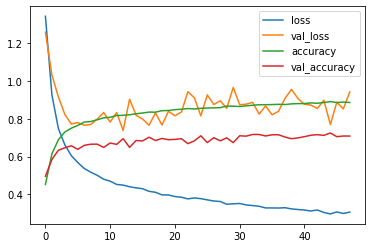

In [46]:
from sklearn.metrics import accuracy_score

loss, accuracy = nn_model.evaluate(codes_test, y_test_hot)

print("LOSS =", loss)
print("ACCURACY =", accuracy)

show_loss(history)

# Grid Search


In [47]:
#def build_classifier():
#    # prepare the codes
#    codes = encoder.predict(X_train)
#
#    assert codes.shape[1:] == (CODE_SIZE,), f"Predicted codes shape must be equal to code size, but {codes.shape[1:]} != {(CODE_SIZE,)}"
#
#    # create the k-neighbors calssifier
#    n_neighbors = num_classes
#    metric = "euclidean"
#
#    nbrs = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
#
#    # fit the model using the codes
#    nbrs.fit(codes, y_train)


def compile_autoencoder(autoencoder, hparams):
    """
    Compile autoencoder with given hyperparams.
    """

    optimizer = hparams["optimizer"]
    loss = hparams["loss_func"]

    autoencoder.compile(optimizer=optimizer, loss=loss)

    return autoencoder


def fit_autoencoder(autoencoder, hparams):
    """
    Fit the autoencoder with given hyperparams on `X_train` with validation `X_test`.
    Please note that the best and last models are saved in `models` folder.
    """

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    callbacks = [early_stopping_callback]

    history = autoencoder.fit(
        x=X_train, y=X_train, 
        epochs=hparams["epochs"], 
        validation_data=(X_test, X_test), 
        batch_size=hparams["batch_size"],
        callbacks=callbacks,
        verbose=0)

    return history


def evaluate_autoencoder(autoencoder):
    """
    Evaluate the autoencoder with `X_test`.
    """
    return autoencoder.evaluate(X_test, X_test, verbose=0)


def run_model(hparams):
    """
    Setup, train and evaluate the autoencoder model with given hyperparams.

    :return: A tuple `(loss, hystory)`
    """
    encoder = build_encoder(DATA_SHAPE, hparams["code_size"])
    decoder = build_decoder(DATA_SHAPE, hparams["code_size"])

    autoencoder = build_autoencoder(encoder, decoder)
    autoencoder = compile_autoencoder(autoencoder, hparams)

    history = fit_autoencoder(autoencoder, hparams)
    loss = evaluate_autoencoder(autoencoder)

    # Note: we may also add the classifier training and evaluation 
    #       to select the best model

    filepath = f'models/encoder_{get_settings()}cs{hparams["code_size"]}-bs{hparams["batch_size"]}.h5'
    encoder.save(filepath)

    return loss, history


def select_model():
    """
    Run the model with hyperparams and save results.

    :return: An array of results with mse, hparams and training history.
    """
    results = []

    hparams_code_sizes = [6, 12, 18, 30, 48, 54, 60, 72]
    hparams_opts = ["adam"]
    hparams_losses = ["mse"]
    hparams_epochs = [150]
    hparams_batch_sizes = [32, 128]

    for code_size in hparams_code_sizes:
        for opt in hparams_opts:
            for loss in hparams_losses:
                for epochs in hparams_epochs:
                    for batch_size in hparams_batch_sizes:

                        hparams = {
                            "code_size": code_size,
                            "optimizer": opt,
                            "loss_func": loss,
                            "epochs": epochs,
                            "batch_size": batch_size
                        }

                        print(f"Starting new run with hparams =", hparams)
                    
                        mse, history = run_model(hparams)

                        print(f"HPARAMS = {hparams}")
                        print(f"MSE = {mse}")
                        print()

                        results += [{"hparams": hparams, "mse": mse, "history": history}]

    return results

Select the best model based on lowest loss.

In [48]:
import time

start = time.time()
results = select_model()
end = time.time()

print(f"Done in {end - start} s")

Starting new run with hparams = {'code_size': 6, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 32}
HPARAMS = {'code_size': 6, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 32}
MSE = 2.386730670928955

Starting new run with hparams = {'code_size': 6, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 128}
HPARAMS = {'code_size': 6, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 128}
MSE = 2.3880417346954346

Starting new run with hparams = {'code_size': 12, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 32}
HPARAMS = {'code_size': 12, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 32}
MSE = 2.3855345249176025

Starting new run with hparams = {'code_size': 12, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 128}
HPARAMS = {'code_size': 12, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 128}
MSE = 2.38629460334

Print a CSV table for models and save them to file

In [49]:
def get_csv(results):
    s = "i,mse,hparams,filepath\n"
    
    for i, result in zip(range(len(results)), results):
        hparams = result["hparams"]
        code_size = hparams["code_size"]
        batch_size = hparams["batch_size"]
        mse = result["mse"]

        filepath = f'models/encoder_{get_settings()}cs{code_size}-bs{batch_size}.h5'

        s += f"{i},{mse},{hparams},{filepath}\n"
    
    return s


def save_results(results, filename=f'models/res_{get_settings()}.csv.txt'):
    with open(filename, mode="w") as f:
        content = get_csv(results)
        f.write(content)


print(get_csv(results))
save_results(results)

i,mse,hparams,filepath
0,2.386730670928955,{'code_size': 6, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 32},models/encoder_oit_allpos_cs6-bs32.h5
1,2.3880417346954346,{'code_size': 6, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 128},models/encoder_oit_allpos_cs6-bs128.h5
2,2.3855345249176025,{'code_size': 12, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 32},models/encoder_oit_allpos_cs12-bs32.h5
3,2.3862946033477783,{'code_size': 12, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 128},models/encoder_oit_allpos_cs12-bs128.h5
4,1.8462462425231934,{'code_size': 18, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 32},models/encoder_oit_allpos_cs18-bs32.h5
5,1.8146566152572632,{'code_size': 18, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 128},models/encoder_oit_allpos_cs18-bs128.h5
6,1.4630745649337769,{'code_size': 30, 'optimizer': 'adam', 'los

Check best model

Model: "functional_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
dense_74 (Dense)             (None, 100)               3100      
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 5)                 505       
Total params: 13,705
Trainable params: 13,705
Non-trainable params: 0
________________________________________________

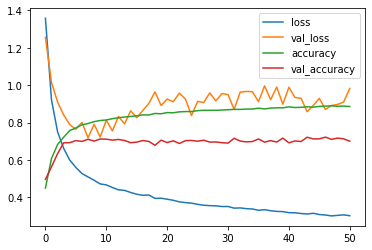

In [52]:
def test_best_model(best_filename):

    def build_nn(code_size):
        inputs = tf.keras.Input((code_size,))
        X = inputs
        X = layers.Dense(100, activation="relu")(X)
        X = layers.Dropout(0.1)(X)
        X = layers.Dense(100, activation="relu")(X)
        X = layers.Dropout(0.1)(X)
        X = layers.Dense(num_classes, activation="softmax")(X)
        outputs = X

        return tf.keras.Model(inputs=inputs, outputs=outputs)

    encoder = tf.keras.models.load_model(best_filename)
    encoder.compile(optimizer="adam", loss="mse")

    codes_train = encoder.predict(X_train)
    codes_test = encoder.predict(X_test)

    nn_model = build_nn(30)

    adam_optimizer = tf.keras.optimizers.Adam()
    loss_funct = tf.keras.losses.CategoricalCrossentropy()

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    callbacks = [early_stopping_callback]

    nn_model.compile(optimizer=adam_optimizer, loss=loss_funct, metrics=["accuracy"])
    nn_model.summary()

    history = nn_model.fit(x=codes_train, y=y_train_hot,
        epochs=100,
        validation_data=(codes_test, y_test_hot), 
        batch_size=128,
        callbacks=callbacks,
        verbose=0)
    
    from sklearn.metrics import accuracy_score

    loss, accuracy = nn_model.evaluate(codes_test, y_test_hot)

    print("LOSS =", loss)
    print("ACCURACY =", accuracy)

    show_loss(history)


test_best_model("./models/encoder_oit_allpos_cs30-bs128.h5")

Plot some results from hparams

In [51]:
#losses_by_code_size_with_batch_32 = list(map(lambda r: r["hparams"]["code_size"], list(filter(lambda r: r["hparams"]["batch_size"] == 32, results)))), #list(map(lambda r: r["mse"], list(filter(lambda r: r["hparams"]["batch_size"] == 32, results))))
#losses_by_code_size_with_batch_128 = list(map(lambda r: r["hparams"]["code_size"], list(filter(lambda r: r["hparams"]["batch_size"] == 128, results))))#, list(map(lambda r: r["mse"], list(filter(lambda r: r["hparams"]["batch_size"] == 128, results))))
#losses_by_code_size_with_batch_256 = list(map(lambda r: r["hparams"]["code_size"], list(filter(lambda r: r["hparams"]["batch_size"] == 256, results))))#, list(map(lambda r: r["mse"], list(filter(lambda r: r["hparams"]["batch_size"] == 256, results))))
#
#
#plt.scatter(losses_by_code_size_with_batch_32[0], losses_by_code_size_with_batch_32[1])
#plt.scatter(losses_by_code_size_with_batch_128[0], losses_by_code_size_with_batch_128[1])
#plt.scatter(losses_by_code_size_with_batch_256[0], losses_by_code_size_with_batch_256[1])
#plt.show()